In [1]:
import sys, os
DMOL_DIR = "../"
sys.path.append(os.path.join(DMOL_DIR, "utils"))
from ml_utils import *
from IPython.core.display import HTML 

import numpy as np
import pandas as pd
import math
import pickle
from itertools import combinations
from collections import Counter
pd.options.display.max_columns = 999
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.decomposition import PCA, KernelPCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from astropy.stats import median_absolute_deviation
from sklearn.pipeline import Pipeline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("../data/class_data.csv")
df_proc = preprocess_df(df, verbose = False)

In [3]:
def get_feature_importance(trained_models, step_name):
    feature_importance_master = pd.DataFrame()
    for i, model in enumerate(trained_models):
        var_names = list(NEW_VAR_MAP['week_1']["Quant"]['Demographics']) + ["gr_revq{}".format(i) for i in range(1, i+2)]
        week_name = "up_to_week_{}".format(i+1)
        df_feature_imp = pd.DataFrame([round(i, 3) for i in model.best_estimator_.named_steps[step_name].feature_importances_], 
                                  index=var_names, columns = [week_name]).sort_values(week_name, ascending = False)
        feature_importance_master = pd.concat([feature_importance_master, df_feature_imp], axis = 1)
    feature_importance_master = feature_importance_master.fillna("-")
    return feature_importance_master

In [4]:
assert(os.path.exists("./plots/"))

### Final Letter Grades Distribution

In [5]:
final_grade = df_proc["gr_gradef"].map(grade_scale_map)
final_grade = final_grade.fillna(final_grade.median())
df_proc["gr_satisfied"] = pd.DataFrame(final_grade > df_proc["pre_badgrade"])[0].map({False: 0, True: 1})

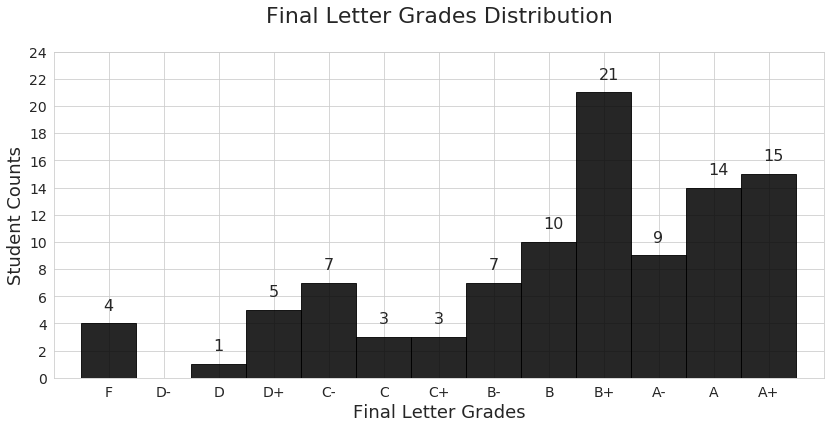

In [6]:
plt.figure(figsize = (13.8, 6))
sns.set_style("whitegrid")
X = plt.hist(final_grade, bins=np.arange(20)-0.5, ec='black', alpha=0.85, color = 'black')

for y_loc, x_loc in zip(X[0][1:14], X[1][1:14]):
    if y_loc != 0:
        plt.text(x_loc + 0.4, y_loc + 1, int(y_loc), fontsize=16)
plt.xlim(0, 14)
plt.yticks(np.arange(0, 25, 2))
plt.xticks(np.arange(1, 14), list(grade_scale_map.keys())[::-1][2:])
plt.tick_params(labelsize=14)
plt.xlabel("Final Letter Grades", fontsize = 18)
plt.ylabel("Student Counts", fontsize = 18)
plt.title("Final Letter Grades Distribution\n", fontsize=22)
plt.savefig("./plots/Grades-Histogram.eps", format='eps', dpi=1200)

### Target Distirbution (Reg)

In [7]:
scores = df_proc["gr_revqf"]
scores = scores.fillna(scores.median())

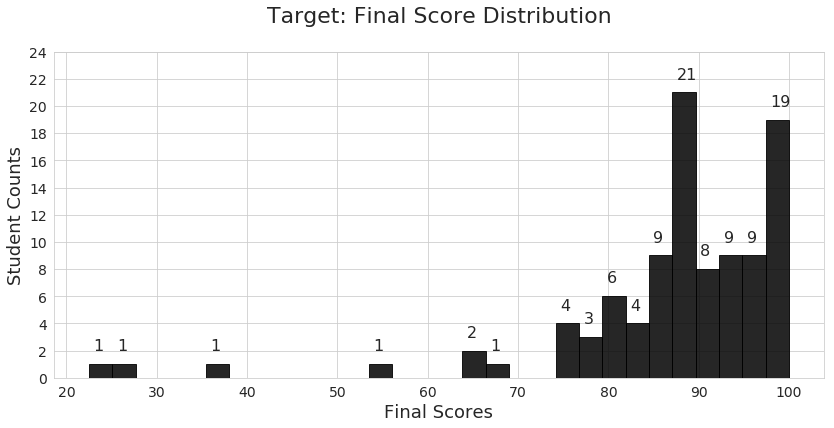

In [8]:
plt.figure(figsize = (13.8, 6))
sns.set_style("whitegrid")
X = plt.hist(scores, bins=30, alpha = 0.85, ec='black', color='black')
for y_loc, x_loc in zip(X[0], X[1]):
    if y_loc != 0:
        plt.text(x_loc + 0.5, y_loc + 1, int(y_loc), fontsize=16)
        
plt.yticks(np.arange(0, 25, 2))
plt.tick_params(labelsize=14)
plt.xlabel("Final Scores", fontsize = 18)
plt.ylabel("Student Counts", fontsize = 18)
plt.title("Target: Final Score Distribution\n", fontsize=22)
plt.savefig("./plots/Target-Distribution.eps", format='eps', dpi=1200)

### Bar Plot: Median Grades 

In [9]:
df_proc["gr_aboveB+"] =  pd.DataFrame(final_grade >= 10)["gr_gradef"].map({False: 0, True: 1})

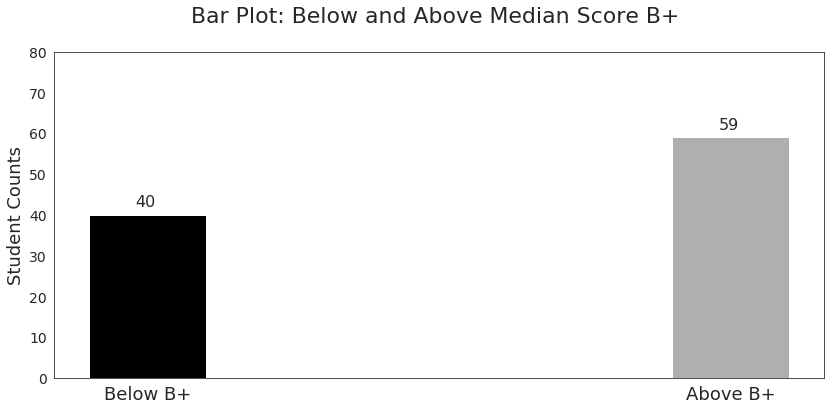

In [10]:
plt.figure(figsize = (13.8, 6))
sns.set_style("white")
num_below, num_above = Counter(df_proc["gr_aboveB+"])[0], Counter(df_proc["gr_aboveB+"])[1]
plt.bar(0.25, num_below, width = 0.1, color='k')
plt.bar(0.75, num_above, width = 0.1, color='#AFAFAF')
plt.text(0.24, num_below + 2, str(num_below), fontsize=16)
plt.text(0.74, num_above + 2, str(num_above), fontsize=16)

plt.yticks(np.arange(0, 81, 10))
plt.xticks([0.25, 0.75], ["Below B+", "Above B+"])
plt.tick_params(labelsize=18, axis='x')
plt.tick_params(labelsize=14, axis='y')

plt.ylabel("Student Counts", fontsize = 18)
plt.title("Bar Plot: Below and Above Median Score B+ \n", fontsize=22)
plt.savefig("./plots/Median-Grade-Barplot.eps", format='eps', dpi=1200)

### Bar Plot: Grade Expectation 

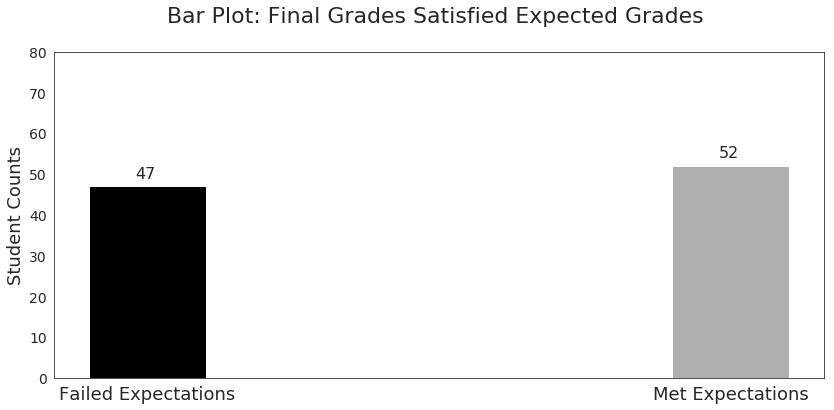

In [11]:
plt.figure(figsize = (13.8, 6))
sns.set_style("white")
num_below, num_above = Counter(df_proc["gr_satisfied"])[0], Counter(df_proc["gr_satisfied"])[1]
plt.bar(0.25, num_below, width = 0.1, color='k')
plt.bar(0.75, num_above, width = 0.1, color='#AFAFAF')
plt.text(0.24, num_below + 2, str(num_below), fontsize=16)
plt.text(0.74, num_above + 2, str(num_above), fontsize=16)

plt.yticks(np.arange(0, 81, 10))
plt.xticks([0.25, 0.75], ["Failed Expectations", "Met Expectations"])
plt.tick_params(labelsize=18, axis='x')
plt.tick_params(labelsize=14, axis='y')

plt.ylabel("Student Counts", fontsize = 18)
plt.title("Bar Plot: Final Grades Satisfied Expected Grades \n", fontsize=22)
plt.savefig("./plots/Grade-Satisfication-Barplot.eps", format='eps', dpi=1200)

### Reg Models (Final Grade Score)

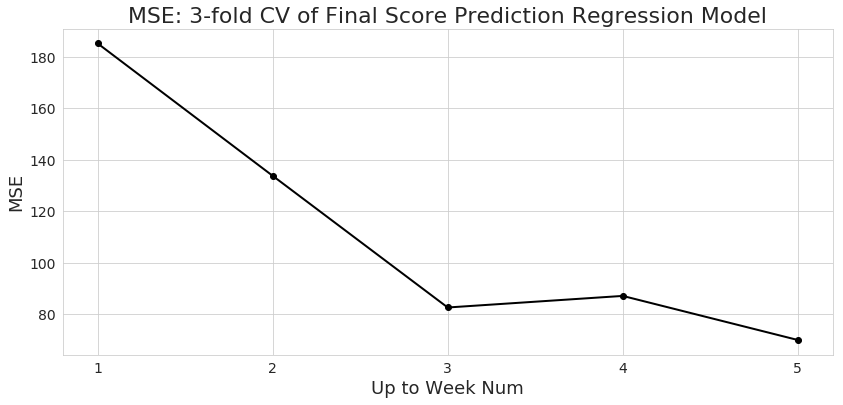

In [12]:
reg = pickle.load(open("../data/quiz_models.pkl", 'rb'))
test_scores = [model.cv_results_['mean_test_score'][model.best_index_] for model in reg]
plt.figure(figsize = (13.8, 6))
sns.set_style("whitegrid")
plt.plot([i for i in range(1, 6)], -np.array(test_scores), '-ko', linewidth = 2)
plt.tick_params(labelsize = 14)
plt.xticks([i for i in range(1, 6)])
plt.xlabel("Up to Week Num", fontsize = 18)
plt.ylabel("MSE", fontsize = 18)
plt.title("MSE: 3-fold CV of Final Score Prediction Regression Model", fontsize = 22)
plt.savefig("./plots/Reg-Model.eps", format='eps', dpi=1200)

In [13]:
FI_reg = get_feature_importance(reg, "reg")

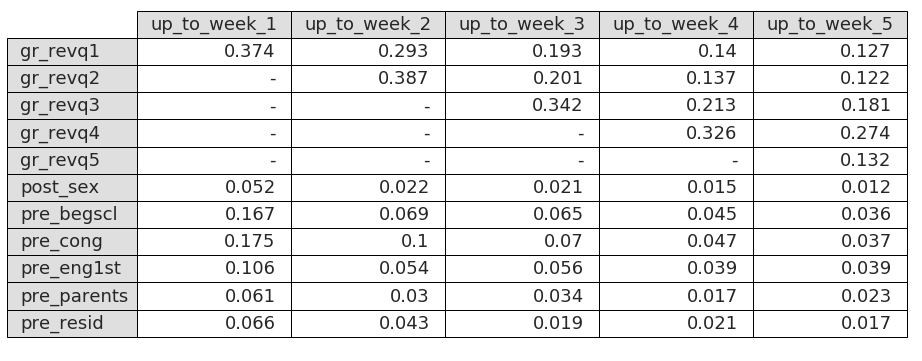

In [14]:
fig, ax = plt.subplots(figsize = (13.8, 6))
ax.axis('off')
sns.set_style("white")
table = plt.table(cellText = FI_reg.values, bbox = [0, 0, 1, 1], rowLabels = FI_reg.index, colLabels = FI_reg.columns, 
          colColours = ["#DFDFDF"] * 5, rowColours = ["#DFDFDF"] * FI_reg.shape[0])
table.set_fontsize(18)
plt.savefig("./plots/Reg-Model-Feature-Importance.eps", format='eps', dpi=1200)

### Classification Model (B+)

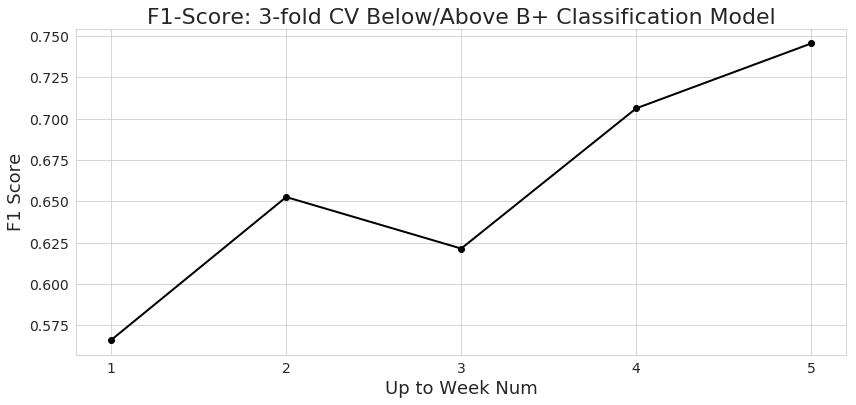

In [15]:
clf_bplus = pickle.load(open("../data/quiz_models_bplus.pkl", 'rb'))
test_scores = [model.cv_results_['mean_test_score'][model.best_index_] for model in clf_bplus]
plt.figure(figsize = (13.8, 6))
sns.set_style("whitegrid")
plt.plot([i for i in range(1, 6)], test_scores, '-ko', linewidth = 2)
plt.tick_params(labelsize = 14)
plt.xticks([i for i in range(1, 6)])
plt.xlabel("Up to Week Num", fontsize = 18)
plt.ylabel("F1 Score", fontsize = 18)
plt.title("F1-Score: 3-fold CV Below/Above B+ Classification Model", fontsize = 22)
plt.savefig("./plots/Clf-Bplus-Model.eps", format='eps', dpi=1200)

In [16]:
FI_clf_bplus = get_feature_importance(clf_bplus, "clf")

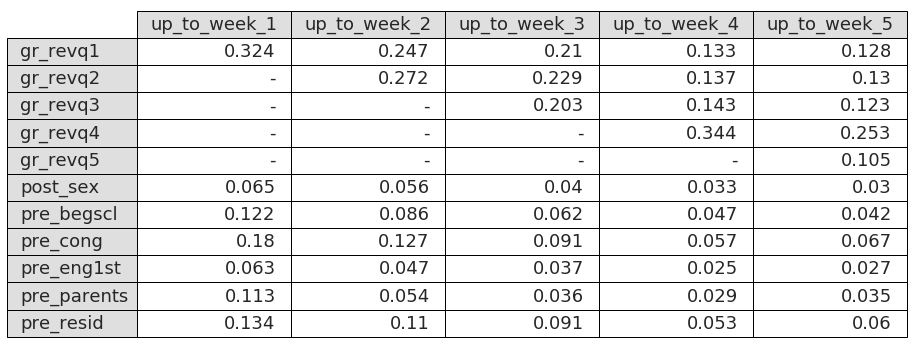

In [17]:
fig, ax = plt.subplots(figsize = (13.8, 6))
ax.axis('off')
sns.set_style("white")
table = plt.table(cellText = FI_clf_bplus.values, bbox = [0, 0, 1, 1], rowLabels = FI_clf_bplus.index, colLabels = FI_clf_bplus.columns, 
          colColours = ["#DFDFDF"] * 5, rowColours = ["#DFDFDF"] * FI_clf_bplus.shape[0])
table.set_fontsize(18)
plt.savefig("./plots/Clf-Bplus-Model-Feature-Importance.eps", format='eps', dpi=1200)

### Classification Model (Grade Expectation)

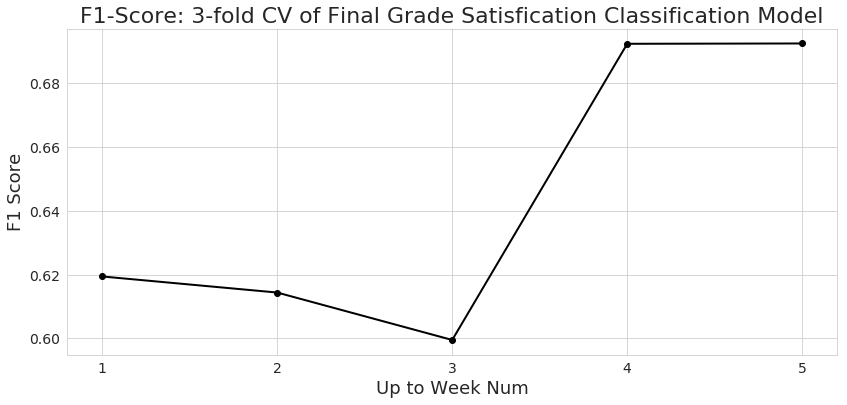

In [18]:
clf_exp = pickle.load(open("../data/quiz_models_satisfied.pkl", 'rb'))
test_scores = [model.cv_results_['mean_test_score'][model.best_index_] for model in clf_exp]
plt.figure(figsize = (13.8, 6))
sns.set_style("whitegrid")
plt.plot([i for i in range(1, 6)], test_scores, '-ko', linewidth = 2)
plt.tick_params(labelsize = 14)
plt.xticks([i for i in range(1, 6)])
plt.xlabel("Up to Week Num", fontsize = 18)
plt.ylabel("F1 Score", fontsize = 18)
plt.title("F1-Score: 3-fold CV of Final Grade Satisfication Classification Model", fontsize = 22)
plt.savefig("./plots/Clf-Expected-Model.eps", format='eps', dpi=1200)

In [19]:
FI_clf_exp = get_feature_importance(clf_exp, "clf")

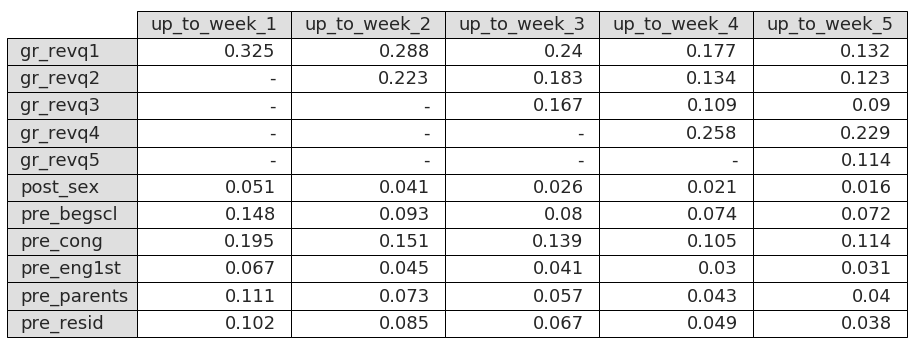

In [20]:
fig, ax = plt.subplots(figsize = (13.8, 6))
ax.axis('off')
sns.set_style("white")
table = plt.table(cellText = FI_clf_exp.values, bbox = [0, 0, 1, 1], rowLabels = FI_clf_exp.index, colLabels = FI_clf_exp.columns, 
          colColours = ["#DFDFDF"] * 5, rowColours = ["#DFDFDF"] * FI_clf_exp.shape[0])
table.set_fontsize(18)
plt.savefig("./plots/Clf-Expected-Model-Feature-Importance.eps", format='eps', dpi=1200)